# SkillsFuture Case Part 2


In [27]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from collections import Counter
from ydata_profiling import ProfileReport


from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from pickle import dump
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [28]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/SkillsFuture Case/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df_test = pd.read_csv('data/fraudTest.csv')
df_train = pd.read_csv('data/fraudTrain.csv')

In [30]:
print(df_train.is_fraud.value_counts())
print(df_test.is_fraud.value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64
is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [31]:
is_fraud_counts = df_train.is_fraud.value_counts().reset_index(name="Count").rename(columns={'index':'is_fraud'})
is_fraud_counts[is_fraud_counts["is_fraud"] == 1.0].Count
is_fraud_counts["Percentage"] = is_fraud_counts["Count"]/len(df_train) * 100
is_fraud_counts

,is_fraud,Count,Percentage
0,0,1289169,99.421135
1,1,7506,0.578865


## EDA

Doing Basic EDA and feature selection

In [9]:
print(df_train.isnull().sum())


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [32]:
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])

# Convert dob to datetime and extract age
df_train['dob'] = pd.to_datetime(df_train['dob'])
df_train['age'] = (pd.to_datetime('today') - df_train['dob']).dt.days // 365

# Check the data types
print(df_train.dtypes)

Unnamed: 0                        int64
trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
age                               int64
dtype: object


In [33]:
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])

# Convert dob to datetime and extract age
df_test['dob'] = pd.to_datetime(df_test['dob'])
df_test['age'] = (pd.to_datetime('today') - df_test['dob']).dt.days // 365

In [11]:
# Group by month and count total transactions
transactions_per_month = df_train.groupby(df_train['trans_date_trans_time'].dt.to_period('M')).size()

fraud_cases_per_month = df_train.groupby(df_train['trans_date_trans_time'].dt.to_period('M'))['is_fraud'].sum()

fraud_rate_per_month = (fraud_cases_per_month / transactions_per_month) * 100

monthly_stats = pd.DataFrame({
    'total_transactions': transactions_per_month,
    'fraud_cases': fraud_cases_per_month,
    'fraud_rate_percent': fraud_rate_per_month
})

# Calculate averages across months
avg_transactions_per_month = transactions_per_month.mean()
avg_fraud_cases_per_month = fraud_cases_per_month.mean()
avg_fraud_rate_per_month = fraud_rate_per_month.mean()

# Add average row to the DataFrame
monthly_stats.loc['Average'] = [avg_transactions_per_month, avg_fraud_cases_per_month, avg_fraud_rate_per_month]

print("Monthly statistics:")
print(monthly_stats)

# Calculate overall fraud rate (across entire dataset)
overall_fraud_rate = (df_train['is_fraud'].sum() / len(df_train)) * 100
print(f"\nOverall fraud rate: {overall_fraud_rate:.2f}%")
print(f"Average monthly transactions: {avg_transactions_per_month:.2f}")
print(f"Average monthly fraud cases: {avg_fraud_cases_per_month:.2f}")
print(f"Average monthly fraud rate: {avg_fraud_rate_per_month:.2f}%")

Monthly statistics:
                       total_transactions  fraud_cases  fraud_rate_percent
trans_date_trans_time                                                     
2019-01                           52525.0        506.0            0.963351
2019-02                           49866.0        517.0            1.036779
2019-03                           70939.0        494.0            0.696373
2019-04                           68078.0        376.0            0.552308
2019-05                           72532.0        408.0            0.562510
2019-06                           86064.0        354.0            0.411322
2019-07                           86596.0        331.0            0.382235
2019-08                           87359.0        382.0            0.437276
2019-09                           70652.0        418.0            0.591632
2019-10                           68758.0        454.0            0.660287
2019-11                           70421.0        388.0            0.550972
2019-

Given that the high number of transactions and low number of fraud cases

If we prioritize recall (trying to catch all fraud cases):

We would generate too many alerts (including many false positives)
With 1000 investigation capacity and 72,000+ transactions, We can only investigate about 1.4% of all transactions
This would quickly exhaust your investigation resources on many non-fraudulent cases

Thus our model should focus on **precision**

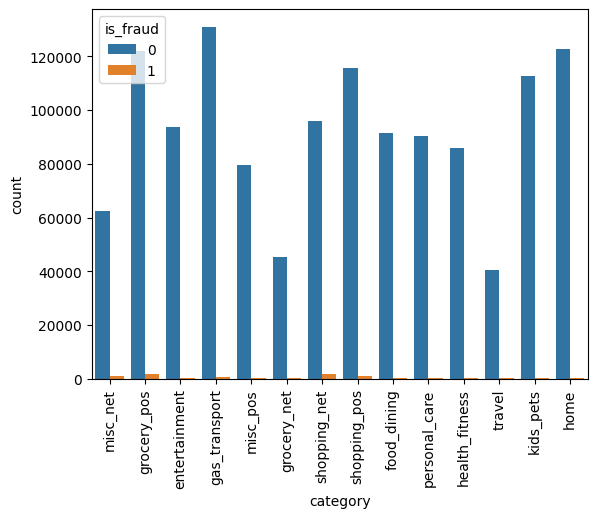

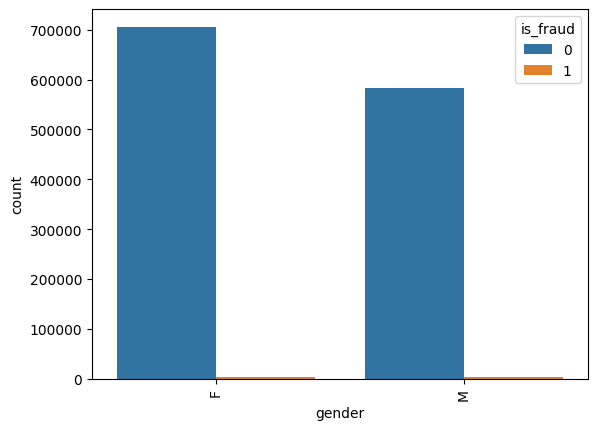

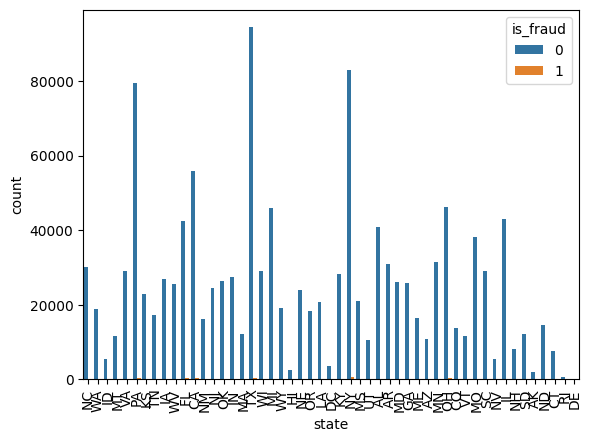

In [22]:
# Check unique values and their distribution
# print(df_train['category'].value_counts())
# print(df_train['gender'].value_counts())
# print(df_train['state'].value_counts())


# Plot the distribution of categorical features with respect to the target
sns.countplot(x='category', hue='is_fraud', data=df_train)
plt.xticks(rotation=90)
plt.show()


sns.countplot(x='gender', hue='is_fraud', data=df_train)
plt.xticks(rotation=90)
plt.show()


sns.countplot(x='state', hue='is_fraud', data=df_train)
plt.xticks(rotation=90)
plt.show()

In [11]:
df_train_profile = ProfileReport(df_train)
df_train_profile

Output hidden; open in https://colab.research.google.com to view.

Given that certain features have high cardinality and high correlation, we drop them from further consideration

In [34]:
# Drop features with high correlation
df_train.drop(["Unnamed: 0","long", "lat", "merch_long", "merch_lat", "zip", "unix_time","cc_num","city_pop"], axis=1, inplace=True)

# Drop features with high cardinality and non-useful
df_train.drop(["trans_date_trans_time", 'first','last','street','dob','trans_num'], axis=1, inplace=True)

df_test.drop(["Unnamed: 0","long", "lat", "merch_long", "merch_lat", "zip", "unix_time","cc_num","city_pop",
              "trans_date_trans_time", 'first','last','street','dob','trans_num'], axis=1, inplace=True)


In [35]:
categ = ['merchant', 'category', 'gender', 'city', 'state', 'job']
# Encode categorical columns
le = LabelEncoder()
df_train[categ] = df_train[categ].apply(le.fit_transform)
df_test[categ] = df_test[categ].apply(le.fit_transform)

## Logistic Regression

We build a baseline logistic regression model to check baseline precision and recall

In [36]:
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']
print(Counter(y_train))

X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']
print(Counter(y_test))

Counter({0: 1289169, 1: 7506})
Counter({0: 553574, 1: 2145})


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

In [41]:
# Train the model with some adjustments for imbalanced data
model = LogisticRegression(
    class_weight='balanced',  # Handle imbalanced classes
    max_iter=1000,
    random_state=42
)


model.fit(X_train, y_train)

pred = model.predict(X_test)

precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

cm= confusion_matrix(y_test,pred)
print(cm)
print(classification_report(y_test,pred))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


[[526115  27459]
 [   531   1614]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.06      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Precision: 0.0555
Recall: 0.7524


Selected threshold: 0.9991
Number of alerts generated: 1000

Precision at k=1000: 0.0170
If you investigate your top 1000 most suspicious transactions, 17 would be actual fraud


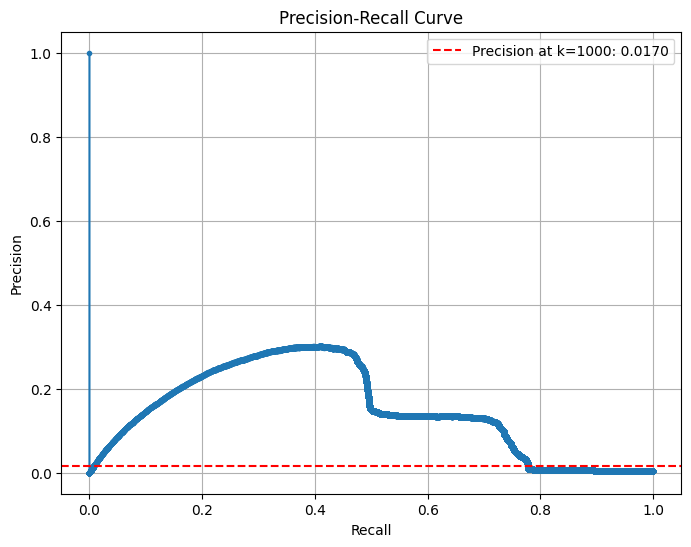

In [42]:
# Get actual predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate precision and recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Set a threshold that would give approximately 1000 predictions per month
# Sort prediction probabilities and find the threshold for top 1000
sorted_probs = np.sort(y_pred_proba)
num_samples = len(sorted_probs)

threshold = sorted_probs[max(0, num_samples - 1000)]

# Apply threshold to make final predictions
y_pred = (y_pred_proba >= threshold).astype(int)

# Print results
print(f"Selected threshold: {threshold:.4f}")
print(f"Number of alerts generated: {sum(y_pred)}")

# Calculate precision at 1000 (how many of top 1000 predictions are actually fraud)
k = min(1000, len(y_pred_proba))
top_k_indices = np.argsort(y_pred_proba)[-k:]
true_positives_at_k = np.sum(y_test.iloc[top_k_indices])
precision_at_k = true_positives_at_k / k

print(f"\nPrecision at k=1000: {precision_at_k:.4f}")
print(f"If you investigate your top 1000 most suspicious transactions, {true_positives_at_k} would be actual fraud")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(true_positives_at_k/k, color='r', linestyle='--',
            label=f'Precision at k=1000: {precision_at_k:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Considering only 17 cases are caught out of 1000, and an overall low precision rate, we need to try another model[link text](https://)

## Neural Networks

Neural networks utilise weights and biases in each node and each layer in order to adjust the weight of the function, eventually converging on an optimum weight for each node to produce the output

In [47]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras import backend as K

model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Get the predictions (probabilities)
y_pred_proba = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype("int32")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 157s 4ms/step - accuracy: 0.9914 - loss: 0.1468 - val_accuracy: 0.9961 - val_loss: 0.0171
Epoch 2/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 195s 4ms/step - accuracy: 0.9941 - loss: 0.0225 - val_accuracy: 0.9947 - val_loss: 0.0181
Epoch 3/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 187s 3ms/step - accuracy: 0.9942 - loss: 0.0210 - val_accuracy: 0.9960 - val_loss: 0.0148
Epoch 4/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.9942 - loss: 0.0206 - val_accuracy: 0.9957 - val_loss: 0.0154
Epoch 5/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 153s 4ms/step - accuracy: 0.9943 - loss: 0.0200 - val_accuracy: 0.9962 - val_loss: 0.0140
Epoch 6/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - accuracy: 0.9943 - loss: 0.0195 - val_accuracy: 0.9961 - val_loss: 0.0136
Epoch 7/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - accuracy: 0.9943 - loss: 0.0191 - val_accuracy: 0.9962 - val_loss: 0.0136
Epoch 8/10
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 152s 4ms/step - ac

Selected threshold: 0.3915
Number of alerts generated: 3087

Precision at k=1000: 0.5700
If you investigate your top 1000 most suspicious transactions, 570 would be actual fraud


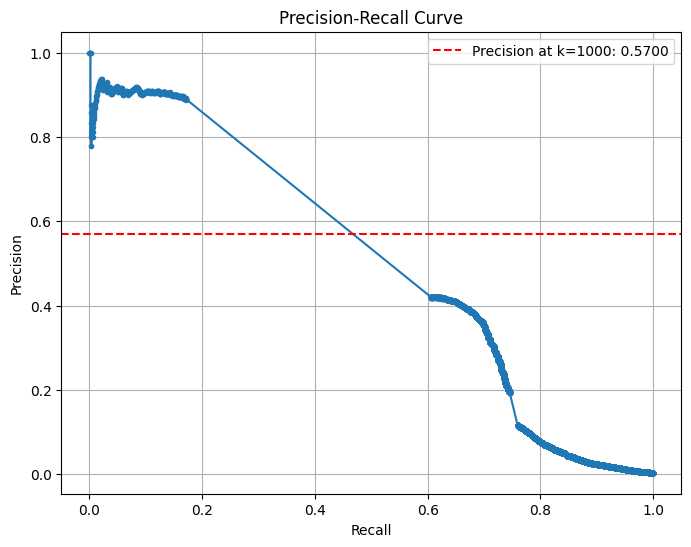

In [57]:
y_pred_proba_flatten = y_pred_proba.flatten()

# Calculate precision and recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_flatten)

# Set a threshold that would give approximately 1000 predictions per month
# Sort prediction probabilities and find the threshold for top 1000
sorted_probs = np.sort(y_pred_proba_flatten)
num_samples = len(sorted_probs)

threshold = sorted_probs[max(0, num_samples - 1000)]

# Apply threshold to make final predictions
y_pred = (y_pred_proba_flatten >= threshold).astype(int)

# Print results
print(f"Selected threshold: {threshold:.4f}")
print(f"Number of alerts generated: {sum(y_pred)}")

# Calculate precision at 1000 (how many of top 1000 predictions are actually fraud)
k = min(1000, len(y_pred_proba_flatten))
top_k_indices = np.argsort(y_pred_proba_flatten)[-k:]
true_positives_at_k = np.sum(y_test.iloc[top_k_indices])
precision_at_k = true_positives_at_k / k

print(f"\nPrecision at k=1000: {precision_at_k:.4f}")
print(f"If you investigate your top 1000 most suspicious transactions, {true_positives_at_k} would be actual fraud")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(true_positives_at_k/k, color='r', linestyle='--',
            label=f'Precision at k=1000: {precision_at_k:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

Extreme gradient boosting is a form of boosting (ensemble learning), using decision trees as base learners to come to a 'democratic' decision. Each tree is able to correct for the mistakes of the previous tree in a sequential manner

In [51]:
from xgboost import XGBClassifier

model = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

cm = confusion_matrix(y_test, pred)
print(cm)
print(classification_report(y_test, pred))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

importance = model.feature_importances_
feature_names = X_train.columns
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
print("\nTop 10 important features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")

[[553127    447]
 [   973   1172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.55      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.77      0.81    555719
weighted avg       1.00      1.00      1.00    555719

Precision: 0.7239
Recall: 0.5464

Top 10 important features:
amt: 0.4870
category: 0.2985
gender: 0.0880
age: 0.0541
job: 0.0225
city: 0.0222
state: 0.0190
merchant: 0.0087


Selected threshold: 0.6262
Number of alerts generated: 1000

Precision at k=1000: 0.8200
If you investigate your top 1000 most suspicious transactions, 820 would be actual fraud


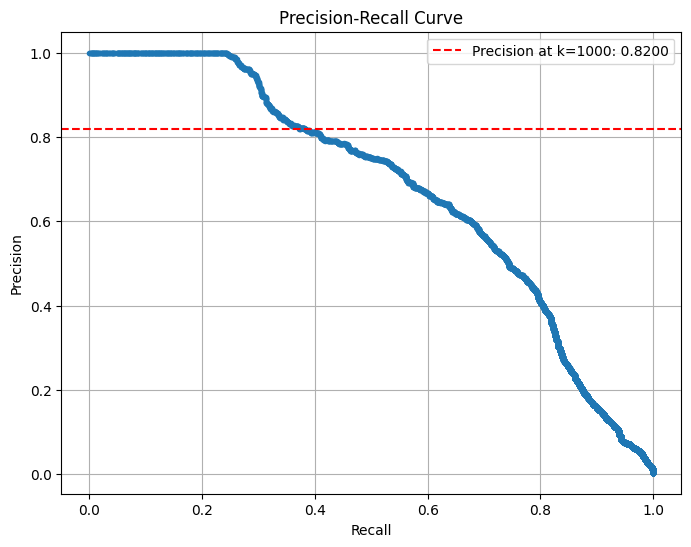

In [45]:

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate precision and recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Set a threshold that would give approximately 1000 predictions per month
# Sort prediction probabilities and find the threshold for top 1000
sorted_probs = np.sort(y_pred_proba)
num_samples = len(sorted_probs)

threshold = sorted_probs[max(0, num_samples - 1000)]

# Apply threshold to make final predictions
y_pred = (y_pred_proba >= threshold).astype(int)

# Print results
print(f"Selected threshold: {threshold:.4f}")
print(f"Number of alerts generated: {sum(y_pred)}")

# Calculate precision at 1000 (how many of top 1000 predictions are actually fraud)
k = min(1000, len(y_pred_proba))
top_k_indices = np.argsort(y_pred_proba)[-k:]
true_positives_at_k = np.sum(y_test.iloc[top_k_indices])
precision_at_k = true_positives_at_k / k

print(f"\nPrecision at k=1000: {precision_at_k:.4f}")
print(f"If you investigate your top 1000 most suspicious transactions, {true_positives_at_k} would be actual fraud")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(true_positives_at_k/k, color='r', linestyle='--',
            label=f'Precision at k=1000: {precision_at_k:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()